In [1]:
from matplotlib import image
from IPython import display
import os
import time
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import utils


In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = image_loader.load_cifar10()

In [3]:
X_train, X_val, X_test = X_train - np.min(X_train), X_val - np.min(X_val), X_test - np.min(X_test)

In [4]:
X_train, X_val, X_test = X_train/np.max(X_train), X_val/np.max(X_val), X_test/np.max(X_test)

In [5]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(40000, 3, 32, 32) (10000, 3, 32, 32) (40000,) (10000,)


Label:  7


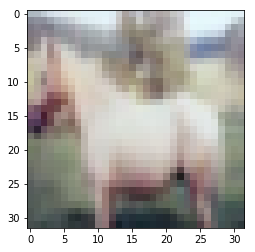

In [6]:
print('Label: ', y_train[10])
plt.imshow(X_train[10].transpose(1,2,0))
plt.show()

In [7]:
iterate_minibatches = Models.iterate_minibatches
compute_loss = Models.compute_loss
Flatten = Models.Flatten
Radamacher_Regularization_p_inf_q_1 = Models.Radamacher_Regularization_p_inf_q_1
VariationalDropout = Models.VariationalDropout

In [10]:
X_train = torch.Tensor(X_train[:20000]).cuda()
y_train = torch.tensor(y_train[:20000], dtype=torch.long).cuda()

X_val = torch.Tensor(X_val).cuda()
y_val = torch.tensor(y_val, dtype=torch.long).cuda()


X_test = torch.Tensor(X_test).cuda()
y_test = torch.tensor(y_test, dtype=torch.long).cuda()

# Testing

In [12]:
def train(model, X_train, y_train, X_val, y_val, num_epochs, batch_size, optimizer, scheduler, random_seed = 123):
    
    np.random.seed(random_seed)
    
    initial_rates = []
    hidden_rates = []
    
    train_loss = []
    train_loss_per_epoch = []
    
    train_extra_loss_per_epoch = []
    
    val_accuracy = []

    for epoch in range(num_epochs):
        model.train(True) # enable dropout / batch_norm training behavior
        scheduler.step()
        
        start_time = time.time()
        
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
                
            logits = model(X_batch)
            loss_net = compute_loss(logits, y_batch)
            loss_reg = Radamacher_Regularization_p_inf_q_1(model, X_batch)
            loss = loss_net + regularizer_weights * loss_reg
            
            train_loss.append(float(loss))
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            

        train_loss_per_epoch.append(np.mean(train_loss[-batch_size :]))
        
        initial_rates.append(model[-6].probs.data.cpu())
        hidden_rates.append(model[-3].probs.data.cpu())    
    
        model.train(False)
        val_batch_acc = []
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(X_batch)
            y_pred = logits.max(1)[1]
            val_batch_acc.append(torch.sum(y_batch == y_pred).cpu().data.numpy() / y_batch.shape[0])

        val_accuracy.append(np.mean(np.array(val_batch_acc)))
        
        display.clear_output(wait=True)
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('# epoch')
        ax1.set_ylabel('objective', color=color)
        ax1.plot(train_loss_per_epoch, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
        ax2.plot(val_accuracy, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss: \t{:.6f}".format(train_loss_per_epoch[-1]))

    return train_loss_per_epoch, initial_rates, hidden_rates

In [13]:
num_epochs = 100
batch_size = 10

regularizer_weights = 1e-3

n_optimization_iter_to_upd_lr = 200
multiplicative_factor_lr = 0.5

learning_rate = 1e-2

torch.random.manual_seed(123)

model = nn.Sequential(nn.Conv2d(3, 32, 5, stride=1),
                      nn.MaxPool2d((3,3), stride=2),
                      nn.ReLU(),
                      nn.Conv2d(32, 64, 5, stride=1),
                      nn.MaxPool2d((3,3), stride=2),
                      nn.ReLU(),
                      Flatten(),
                      torch.nn.Linear(1024, 1024),
                      VariationalDropout(torch.Tensor([0.8] * 1024).cuda(), 'deterministic'),
                      torch.nn.ReLU(),
                      torch.nn.Linear(1024, 1024),
                      VariationalDropout(torch.Tensor([0.8] * 1024).cuda(), 'deterministic'),
                      torch.nn.ReLU(), 
                      torch.nn.Linear(1024, 10), 
                     )
model.cuda()

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_optimization_iter_to_upd_lr,
                                            gamma=multiplicative_factor_lr)


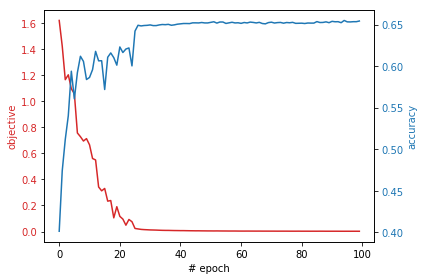

Epoch 100 of 100 took 22.366s
  training loss: 	0.002534


In [14]:
train_loss_per_epoch, initial_rates, hidden_rates = train(model, X_train, y_train, X_val, y_val,
                                                          num_epochs, batch_size, optimizer, scheduler)

In [20]:
initial_rates_new = []
hidden_rates_new = []

for it in initial_rates:
    initial_rates_new.append(it.numpy())
    
for it in hidden_rates:
    hidden_rates_new.append(it.numpy())

In [21]:
initial_rates_new = np.array(initial_rates_new)
hidden_rates_new = np.array(hidden_rates_new)

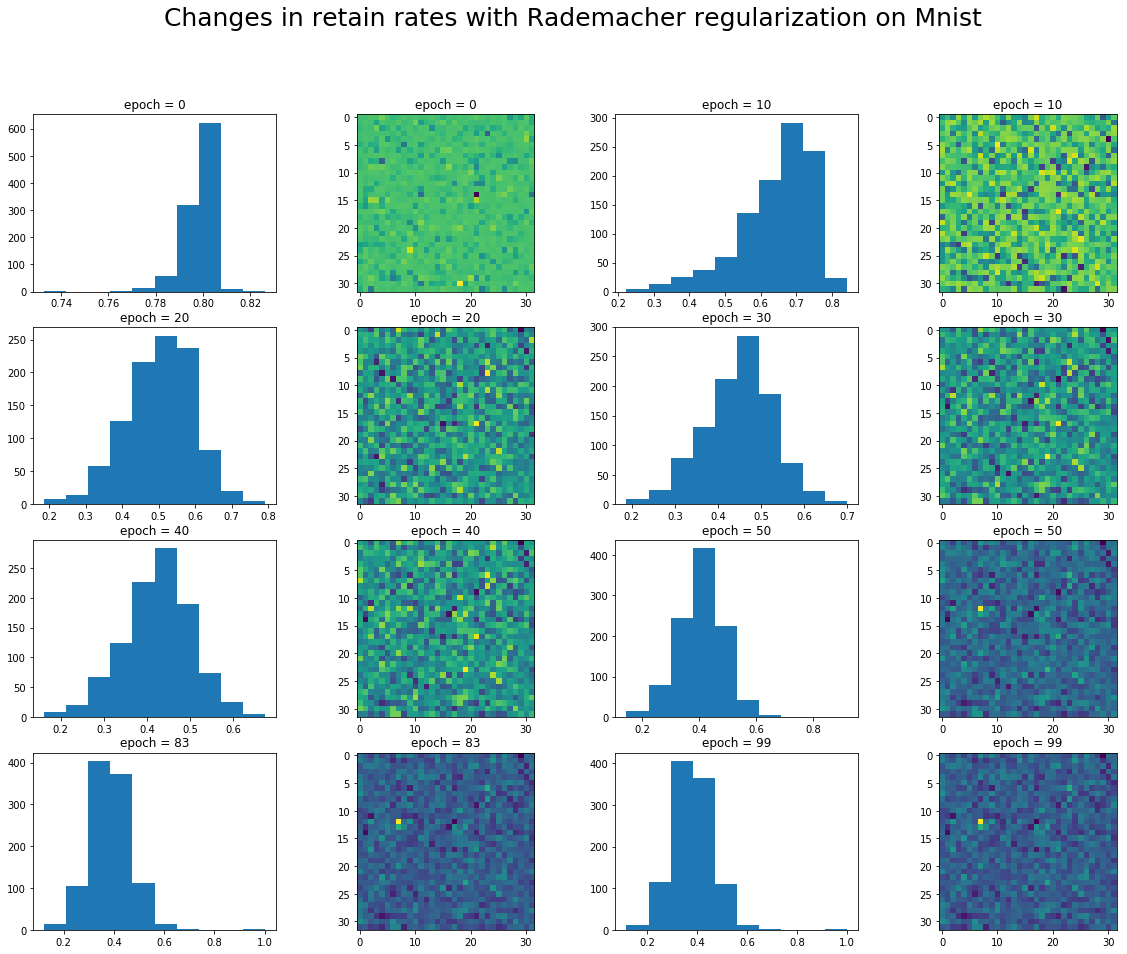

In [25]:
fig = plt.figure(figsize = (20, 15))
plt.suptitle("Changes in retain rates with Rademacher regularization on Mnist", size = 25)

for it, dim in enumerate([0, 10, 20, 30, 40, 50, 83, 99]):
    ax = fig.add_subplot(4, 4, 2*it + 1)
    ax.hist(initial_rates_new[dim])
    ax.set_title("epoch = {}".format(dim))
    ax = fig.add_subplot(4, 4, 2*it + 2)
    ax.imshow(initial_rates_new[dim].reshape((32, 32)))
    ax.set_title("epoch = {}".format(dim))

#plt.tight_layout()
plt.show()